# Translational mapping

In this notebook we explicitely model the link between the regulatory and structural embeddings of the U2OS cells and evaluate their generalizability.

---


## 0. Enviromental setup

We first load the required packages and define a number of helper functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GroupShuffleSplit,
    LeaveOneGroupOut,
)
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.neighbors import NearestNeighbors
from collections import Counter


seed = 1234

device = "cpu"

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def train_model(
    model,
    optimizer,
    criterion,
    data_dict,
    n_epochs=1000,
    early_stopping=50,
    device="cpu",
):

    best_val_loss = np.infty
    best_epoch = 0
    best_model_weights = None
    es_counter = 0

    for i in range(n_epochs):
        if es_counter > early_stopping:
            break
        for mode in ["train", "val"]:
            loss = process_single_epoch(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                data=data_dict[mode],
                mode=mode,
            )
            # print("{} loss: {}".format(mode.upper(), loss))

            if mode == "val":
                if loss < best_val_loss:
                    best_val_loss = loss
                    best_epoch = i
                    best_model_weights = copy.deepcopy(model.state_dict())
                else:
                    es_counter += 1

    model.load_state_dict(best_model_weights)

    for mode in ["train", "val", "test"]:
        loss = process_single_epoch(
            model, optimizer, criterion, data_dict[mode], "test"
        )
        print("{} loss: {}".format(mode.upper(), loss))

    return model


def process_single_epoch(model, optimizer, criterion, data, mode, device="cpu"):
    total_loss = 0
    model.to(device)
    if mode == "train":
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    for inputs, labels, _ in data:
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(mode == "train"):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * outputs.size(0)

            # backward + optimize only if in training phase
        if mode == "train":
            loss.backward()
            optimizer.step()

    total_loss /= len(data.dataset)
    return total_loss

<IPython.core.display.Javascript object>

In [3]:
class IndexedTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, groups):
        super().__init__()
        self.data = data
        self.labels = labels
        self.groups = groups

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.groups[idx]

    def __len__(self):
        return len(self.groups)

<IPython.core.display.Javascript object>

In [4]:
def get_data_dict(
    data,
    labels,
    val_test_size=[0.2, 0.2],
    batch_size=32,
    group_labels=None,
    scale_x=True,
    scale_y=False,
    random_state=1234,
):

    idc = list(range(len(data)))
    if group_labels is None:
        train_val_idc, test_idc = train_test_split(
            idc, test_size=val_test_size[1], random_state=seed
        )
        train_idc, val_idc = train_test_split(
            train_val_idc, test_size=(val_test_size[0] / (1 - val_test_size[1]))
        )
    else:
        gss = GroupShuffleSplit(
            n_splits=2, test_size=val_test_size[1], random_state=random_state
        )
        train_val_idc, test_idc = next(gss.split(idc, groups=group_labels))
        gss = GroupShuffleSplit(
            n_splits=2,
            test_size=(val_test_size[0] / (1 - val_test_size[1])),
            random_state=seed,
        )
        train_idc, val_idc = next(
            gss.split(train_val_idc, groups=group_labels[train_val_idc])
        )

    train_data, train_labels = data.iloc[train_idc], labels.iloc[train_idc]
    val_data, val_labels = data.iloc[val_idc], labels.iloc[val_idc]
    test_data, test_labels = data.iloc[test_idc], labels.iloc[test_idc]

    if scale_x:
        sc = StandardScaler().fit(train_data)
        train_data = sc.transform(train_data)
        val_data = sc.transform(val_data)
        test_data = sc.transform(test_data)

    if scale_y:
        sc = StandardScaler().fit(train_labels)
        train_labels = sc.transform(train_labels)
        val_labels = sc.transform(val_labels)
        test_labels = sc.transform(test_labels)

    train_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(train_data)),
        torch.FloatTensor(np.array(train_labels)),
        list(labels.iloc[train_idc].index),
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(val_data)),
        torch.FloatTensor(np.array(val_labels)),
        list(labels.iloc[val_idc].index),
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(test_data)),
        torch.FloatTensor(np.array(test_labels)),
        list(labels.iloc[test_idc].index),
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {"train": train_loader, "val": val_loader, "test": test_loader}

<IPython.core.display.Javascript object>

In [5]:
def evaluate_top_k_accuracy(preds, labels, node_embs, k=5, random_state=1234):
    np.random.seed(random_state)
    k_correct = 0
    k_baseline_correct = 0
    neigh = NearestNeighbors(n_neighbors=k, p=2)
    targets = np.array(node_embs.index)
    counts = Counter(labels)
    most_common = list(sorted(counts, key=counts.get, reverse=True))
    # print(most_common)
    fitted_neigh = neigh.fit(np.array(node_embs))

    neighbor_preds = fitted_neigh.kneighbors(preds, k, return_distance=False)
    for i in range(len(neighbor_preds)):
        if labels[i] in targets[neighbor_preds[i]]:
            k_correct += 1
        if labels[i] in np.random.choice(targets, size=k):
            k_baseline_correct += 1
    return k_correct / len(labels), k_baseline_correct / len(labels)

<IPython.core.display.Javascript object>

In [6]:
def get_preds_label_dict(model, data):
    preds = []
    labels = []

    model.eval()

    for batch_inputs, _, batch_labels in data:
        batch_preds = model(batch_inputs)
        preds.extend(list(batch_preds.clone().detach().numpy()))
        labels.extend(list(batch_labels))
    return np.array(preds), np.array(labels)

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the different data sets that we will use for the modelling and evaluation of the translational mappings. The first data set includes all structural embeddings from data held-out during training as well as the regulatory embeddings of the 244 genes that are part of the inferred interactome.

In [7]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv.csv", index_col=0
)
node_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
CDCA2,-0.046519,-0.049060,-0.065633,0.102739,-0.037012,0.067560,0.070266,-0.008673,0.128273,0.004020,...,-0.071056,-0.156410,0.006000,0.093432,0.034559,0.010527,-0.045864,0.068302,0.115374,-0.101571
APPBP2,-0.093607,-0.018010,0.060400,-0.022461,0.071339,0.044652,-0.002030,0.008269,-0.100545,-0.035760,...,-0.100010,0.168263,-0.103005,-0.055163,0.053544,-0.075707,0.119875,0.000469,0.004186,0.123274
TK1,0.023958,0.160870,-0.038898,-0.067761,-0.060810,-0.001184,0.000734,0.029148,0.024501,-0.096013,...,0.057610,-0.050949,-0.017972,0.008282,-0.003922,-0.061075,0.055963,0.034356,0.079510,-0.078223
MMP2,-0.036499,-0.147354,0.082521,0.133464,0.180986,-0.040401,0.066718,-0.040661,-0.171430,0.154789,...,-0.090356,0.352892,0.012735,-0.153441,-0.086582,0.092603,0.052464,0.000355,-0.323068,0.277830
PRKACA,0.021894,0.071289,0.021641,-0.079990,0.044919,-0.082366,0.013962,-0.063172,-0.081244,-0.032706,...,0.062312,0.063952,-0.050152,0.112115,-0.041111,0.073021,0.032152,-0.068759,-0.117734,0.067075


<IPython.core.display.Javascript object>

After having loaded the regulatory embeddings, we will now load the structural embeddings defined by the embeddings of the images held-out during the different folds of the cross-validation. Note that we do not group the data of the individual folds as the inferred models map to different latent spaces. We will also decode the numerical labels.

In [8]:
label_dict = {
    "AKT1S1": 0,
    "APC": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CSNK1E": 11,
    "CXXC4": 12,
    "DIABLO": 13,
    "E2F1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "FGFR3": 18,
    "FOXO1": 19,
    "GLI1": 20,
    "HRAS": 21,
    "IRAK4": 22,
    "JUN": 23,
    "KRAS": 24,
    "MAP2K3": 25,
    "MAP3K2": 26,
    "MAP3K5": 27,
    "MAP3K9": 28,
    "MAPK7": 29,
    "MOS": 30,
    "MYD88": 31,
    "PIK3R2": 32,
    "PKIA": 33,
    "PRKACA": 34,
    "PRKCE": 35,
    "RAF1": 36,
    "RELB": 37,
    "RHOA": 38,
    "SMAD3": 39,
    "SMAD4": 40,
    "SMO": 41,
    "SRC": 42,
    "SREBF1": 43,
    "TRAF2": 44,
    "TSC2": 45,
    "WWTR1": 46,
}

label_dict = {v: k for k, v in label_dict.items()}


img_embs_dict = {}
for i in range(4):
    img_embs = pd.read_hdf(
        "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_{}/test_latents.h5".format(
            i
        )
    )
    img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
    img_embs_dict["fold{}".format(i)] = img_embs

<IPython.core.display.Javascript object>

In [9]:
img_node_embs_dict = {}
shared_targets = set(node_embs.index).intersection(label_dict.values())
for i in range(4):
    filtered_img_embs = img_embs_dict["fold{}".format(i)]
    filtered_img_embs = filtered_img_embs.loc[
        filtered_img_embs.labels.isin(shared_targets)
    ]
    filtered_node_embs = node_embs.loc[filtered_img_embs.labels]
    filtered_img_embs = filtered_img_embs.iloc[:, :-1]
    img_node_embs_dict["fold{}".format(i)] = filtered_img_embs, filtered_node_embs

<IPython.core.display.Javascript object>

---

## 3. Exploratory data analysis

As a first step, we will look at the distribution of the labels in the held-out data of the different folds to better understand how the distribution varies across folds. Note that the data was split in a stratified manner such that the total number of nuclei is roughly the same across folds yet nuclei from the same image are guaranteed to end up in the same image. Thus, we expect some class imbalance across the different folds.

In [10]:
label_counts = []
labels = []
folds = []
fold_keys = list(img_embs_dict.keys())
for i in range(len(fold_keys)):
    label_count = img_embs_dict[fold_keys[i]]["labels"].value_counts()
    folds.extend([str(i)] * len(label_count))
    label_counts.append(label_count)
    labels.extend(list(label_count.index))
label_counts = pd.DataFrame(np.array(pd.concat(label_counts)), columns=["count"])
label_counts["label"] = list(labels)
label_counts["fold"] = folds

<IPython.core.display.Javascript object>

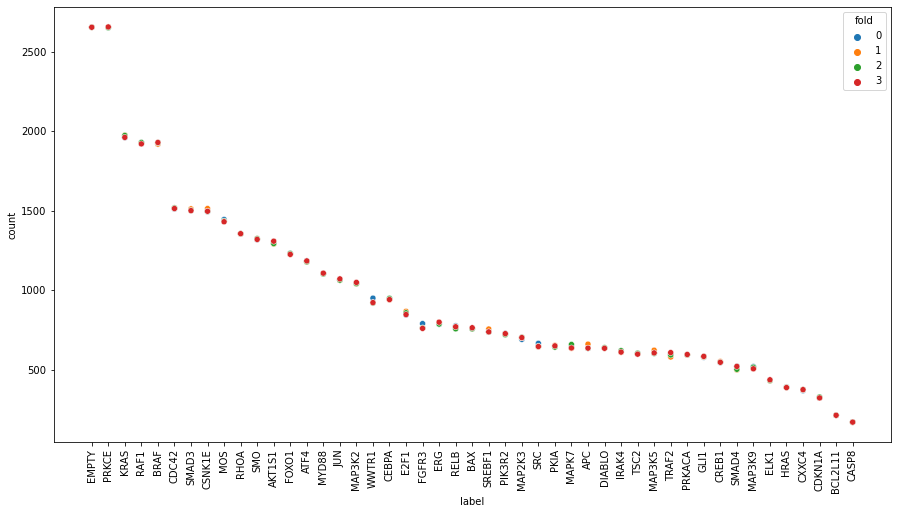

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(figsize=[15, 8])
ax = sns.scatterplot(data=label_counts, x="label", y="count", hue="fold", ax=ax)
plt.xticks(rotation=90)
plt.show()

As mentioned earlier there is quite some variance in the relative distribution of the individual conditions. For instance we have roughly 2700 samples of MAP3K5 as the majority class in fold 2 and just 1600-1800 in the remaining folds. We are working on improving that.

---

## 4. Translational analyses

We will now use the different embeddings of the three different folds in order to model the link between the regulatory and structural space, by given a structural embedding predict the corresponding regulatory embedding. To this end, we will train a linear model for each held-out fold data. To assess the performance, we will evaluate the mapping in three distinct settings:
1. Split the data on a single-nuclei basis, i.e. samples of the same overexpression condition might end up in both the training, validation and test set.
2. Split the data on a OE condition level, i.e. samples of the a certain overexpression condition will be ending up in either of the training, validation and test set.
3. Leave-one-target out cross-validation

We will quickly setup the linear model as well as the corresponding optimizer used for that inference.

In [27]:
model = nn.Sequential(
    #nn.Linear(1024, 1024),
    #nn.PReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

<IPython.core.display.Javascript object>

---

### 4.1. Baseline prediction: Nuclei split

We start of with splitting the data into a training, validation and testing set without distinguishing between OE conditions. This will serve as a baseline of how well we can translate between the two spaces within sample.

In [13]:
img_embs_fold0, node_embs_fold0 = img_node_embs_dict["fold3"]

<IPython.core.display.Javascript object>

In [59]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=None,
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [30]:
fitted_model = train_model(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
)

  5%|▌         | 53/1000 [01:30<26:51,  1.70s/it]


TRAIN loss: 0.00192393100237769
VAL loss: 0.002300289320209842
TEST loss: 0.002309364414966968


<IPython.core.display.Javascript object>

In [36]:
ks = [1, 3, 5, 10, 20, 50]
for mode in ["train", "val", "test"]:
    topk_accs = []
    topk_base_accs = []
    preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
    for k in ks:
        topk_acc, topk_base_acc = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
        topk_accs.append(topk_acc)
        topk_base_accs.append(topk_base_acc)
    print("{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4)))
    print(
        "{} top-{} baseline accuracies: {}".format(
            mode.upper(), ks, np.round(topk_base_accs, 4)
        )
    )
    print(" ")

TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1757 0.2801 0.3376 0.4263 0.5289 0.7108]
TRAIN top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0047 0.0121 0.0204 0.0395 0.0767 0.1834]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.1415 0.2257 0.2772 0.3636 0.4638 0.6373]
VAL top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0033 0.0131 0.0182 0.0396 0.0763 0.1769]
 
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.13   0.2163 0.2689 0.351  0.4474 0.6358]
TEST top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0056 0.0111 0.0247 0.0402 0.078  0.1813]
 


<IPython.core.display.Javascript object>

We see that the top-k accuracy suggest indeed a prediction that is better than naive baseline that simply predicts the k-most frequent targets for k<20 for larger k we see that the baseline outperforms the fitted model. The performances of the model on the training, validation and test set are highly comparable.

---

### 4.2. Out-of-sample prediction

In [14]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [19]:
labels = []
for _, _, label in data_dict["test"].dataset:
    labels.append(label)
print(Counter(labels))

Counter({'KRAS': 1961, 'SMO': 1320, 'WWTR1': 923, 'ERG': 800, 'SREBF1': 739, 'CREB1': 548, 'MAP3K9': 507, 'CDKN1A': 324, 'BCL2L11': 215})


<IPython.core.display.Javascript object>

In [21]:
labels = []
for _, _, label in data_dict["val"].dataset:
    labels.append(label)
print(Counter(labels))

Counter({'BRAF': 1714, 'AKT1S1': 1309, 'CEBPA': 942, 'JUN': 938, 'PRKCE': 771, 'FGFR3': 661, 'APC': 637, 'CDKN1A': 324, 'FOXO1': 313, 'BCL2L11': 215, 'CDC42': 215, 'IRAK4': 112, 'CREB1': 97})


<IPython.core.display.Javascript object>

In [38]:
model = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

<IPython.core.display.Javascript object>

In [39]:
fitted_model = train_model(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
)

  4%|▍         | 39/1000 [01:03<25:56,  1.62s/it]


TRAIN loss: 0.001627825389069915
VAL loss: 0.0034684356953167635
TEST loss: 0.0046605971444239275


<IPython.core.display.Javascript object>

In [40]:
ks = [1, 3, 5, 10, 20, 50]
for mode in ["train", "val", "test"]:
    topk_accs = []
    topk_base_accs = []
    preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
    for k in ks:
        topk_acc, topk_base_acc = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
        topk_accs.append(topk_acc)
        topk_base_accs.append(topk_base_acc)
    print("{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4)))
    print(" ")

TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.2155 0.3367 0.3991 0.4903 0.5938 0.7714]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.1278 0.2168 0.2718 0.3541 0.4439 0.5656]
 
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.152  0.2255 0.2622 0.3252 0.396  0.5117]
 


<IPython.core.display.Javascript object>

Note that for the held-out configuration the baseline accuracies are not reliable as those correspond to the most frequent classes in the corresponding data set.

---

### 4.3. Leave-one-out cross-validation

Finally, we will apply leave-one-target out crossvalidation.

In [41]:
def get_logo_data_dicts(
    data,
    labels,
    group_labels,
    val_size=0.1,
    batch_size=128,
    random_state=1234,
    scale_x=True,
    scale_y=False,
):
    logo = LeaveOneGroupOut()
    data_dicts = []
    idc = list(range(len(labels)))
    for train_val_idc, test_idc in logo.split(idc, groups=group_labels):
        gss = gss = GroupShuffleSplit(
            n_splits=2, test_size=val_size, random_state=random_state
        )
        train_idc, val_idc = next(
            gss.split(train_val_idc, groups=group_labels[train_val_idc])
        )

        train_data, train_labels = data.iloc[train_idc], labels.iloc[train_idc]
        val_data, val_labels = data.iloc[val_idc], labels.iloc[val_idc]
        test_data, test_labels = data.iloc[test_idc], labels.iloc[test_idc]

        if scale_x:
            sc = StandardScaler().fit(train_data)
            train_data = sc.transform(train_data)
            val_data = sc.transform(val_data)
            test_data = sc.transform(test_data)

        if scale_y:
            sc = StandardScaler().fit(train_labels)
            train_labels = sc.transform(train_labels)
            val_labels = sc.transform(val_labels)
            test_labels = sc.transform(test_labels)

        train_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(train_data)),
            torch.FloatTensor(np.array(train_labels)),
            list(labels.iloc[train_idc].index),
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(val_data)),
            torch.FloatTensor(np.array(val_labels)),
            list(labels.iloc[val_idc].index),
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        test_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(test_data)),
            torch.FloatTensor(np.array(test_labels)),
            list(labels.iloc[test_idc].index),
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        data_dict = {"train": train_loader, "val": val_loader, "test": test_loader}
        data_dicts.append(data_dict)
    return data_dicts

<IPython.core.display.Javascript object>

In [60]:
data_dicts = get_logo_data_dicts(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_size=0.1,
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [61]:
topk_test_accs = []
lo_labels = []
for i in tqdm(range(len(data_dicts))):
    data_dict = data_dicts[i]

    model = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.PReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 128),
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    fitted_model = train_model(
        model=model,
        data_dict=data_dict,
        optimizer=optimizer,
        criterion=criterion,
        n_epochs=100,
        early_stopping=5,
    )

    ks = [1, 3, 5, 10, 20, 50]
    for mode in ["train", "val", "test"]:
        topk_accs = []
        preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
        if mode == "test":
            lo_label = np.unique(labels)[0]
            lo_labels.append(lo_label)
            print("Left-out label: {}".format(lo_label))
        for k in ks:
            topk_acc, _ = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
            topk_accs.append(topk_acc)
        print(
            "{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4))
        )
        print("---")
    topk_test_accs.append(np.array(topk_accs))

  0%|          | 0/43 [00:00<?, ?it/s]

TRAIN loss: 0.0022206754788144756
VAL loss: 0.0023525729130581905
TEST loss: 0.0008149518446592689
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1454 0.2376 0.2935 0.3843 0.4866 0.6644]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.08   0.1316 0.1608 0.2178 0.2881 0.4789]
---
Left-out label: AKT1S1


  2%|▏         | 1/43 [00:51<36:22, 51.97s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.4576 0.6631 0.8067 0.9312 0.9878 1.    ]
---
TRAIN loss: 0.0021711638674846837
VAL loss: 0.00548465034798354
TEST loss: 0.005221507965266892
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1483 0.2487 0.3026 0.3888 0.4839 0.659 ]
---


  5%|▍         | 2/43 [01:30<30:04, 44.02s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0361 0.0746 0.0955 0.1382 0.1836 0.3577]
---
Left-out label: APC
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0063 0.0078 0.0235 0.0502 0.0848 0.1476]
---
TRAIN loss: 0.002196851609405037
VAL loss: 0.0026375435890006057
TEST loss: 0.0017127389128551768
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1465 0.2446 0.2976 0.3829 0.4832 0.6562]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0537 0.1059 0.1399 0.2024 0.2808 0.4627]
---
Left-out label: ATF4


  7%|▋         | 3/43 [02:18<30:43, 46.10s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0633 0.108  0.1418 0.2135 0.3966 0.719 ]
---
TRAIN loss: 0.002188226283102135
VAL loss: 0.004991355762682024
TEST loss: 0.001903041773414836
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1519 0.2439 0.295  0.3808 0.4789 0.6581]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0344 0.0682 0.0924 0.139  0.1974 0.4043]
---
Left-out label: BAX


  9%|▉         | 4/43 [02:59<28:36, 44.02s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1124 0.1529 0.1856 0.2562 0.3503 0.5908]
---
TRAIN loss: 0.002585948020969944
VAL loss: 0.005957239478906161
TEST loss: 0.0024448357847367606
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1274 0.216  0.2716 0.3648 0.4725 0.6599]
---


 12%|█▏        | 5/43 [03:35<25:52, 40.87s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0192 0.0413 0.0672 0.1038 0.1504 0.2672]
---
Left-out label: BCL2L11
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.0279 0.5116]
---
TRAIN loss: 0.0024408231513153244
VAL loss: 0.004981612612663673
TEST loss: 0.002018320657956926
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.133  0.2258 0.2774 0.3636 0.4625 0.6417]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.038  0.08   0.1126 0.1698 0.2563 0.4316]
---
Left-out label: BRAF


 14%|█▍        | 6/43 [04:11<24:20, 39.47s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.182  0.2654 0.2986 0.3582 0.4526 0.6159]
---
TRAIN loss: 0.002046635064595447
VAL loss: 0.0056564024743577575
TEST loss: 0.002093468126732596
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1529 0.2479 0.3033 0.3922 0.4924 0.684 ]
---


 16%|█▋        | 7/43 [04:55<24:32, 40.90s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.02   0.0504 0.0734 0.1214 0.1827 0.2876]
---
Left-out label: CASP8
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0291 0.0407 0.0698 0.1105 0.1977 0.4651]
---
TRAIN loss: 0.0023309111493266363
VAL loss: 0.002561701254282067
TEST loss: 0.0018114819552176086
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1306 0.2183 0.2701 0.3566 0.4574 0.6451]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0496 0.1038 0.1297 0.1848 0.2634 0.4337]
---
Left-out label: CDC42


 19%|█▊        | 8/43 [05:38<24:18, 41.66s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0911 0.1744 0.2087 0.2688 0.3587 0.6565]
---
TRAIN loss: 0.0023808927952430896
VAL loss: 0.005927400012232912
TEST loss: 0.02497429356990773
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1355 0.2266 0.2779 0.3684 0.4753 0.6581]
---


 21%|██        | 9/43 [06:17<23:01, 40.64s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0451 0.08   0.1029 0.1449 0.2088 0.3492]
---
Left-out label: CDKN1A
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0. 0. 0. 0. 0. 0.]
---
TRAIN loss: 0.002218699841388083
VAL loss: 0.0051024315343601405
TEST loss: 0.001859280419429159
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1404 0.2311 0.2856 0.3737 0.4757 0.6537]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0395 0.0813 0.1139 0.1779 0.2514 0.4385]
---
Left-out label: CEBPA


 23%|██▎       | 10/43 [07:02<23:08, 42.07s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1008 0.224  0.311  0.4066 0.5403 0.7314]
---
TRAIN loss: 0.002066996979245394
VAL loss: 0.006617807387011354
TEST loss: 0.002878174318313381
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1505 0.2433 0.2989 0.3925 0.4963 0.6813]
---


 26%|██▌       | 11/43 [07:45<22:31, 42.25s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0047 0.0103 0.0156 0.0387 0.0643 0.1462]
---
Left-out label: CREB1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.    0.    0.    0.    0.    0.042]
---
TRAIN loss: 0.0020261342503192542
VAL loss: 0.006032856063253871
TEST loss: 0.0028092528183786374
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1563 0.2602 0.3186 0.415  0.5168 0.6856]
---


 28%|██▊       | 12/43 [08:34<22:55, 44.36s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.008  0.0234 0.0371 0.0682 0.1087 0.2063]
---
Left-out label: DIABLO
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0142 0.0487 0.0849 0.1352 0.195  0.3553]
---
TRAIN loss: 0.0023377628380796853
VAL loss: 0.00570832661216968
TEST loss: 0.004174623163944145
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1454 0.2385 0.2939 0.3805 0.477  0.653 ]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0123 0.0325 0.0482 0.0836 0.127  0.3008]
---
Left-out label: E2F1


 30%|███       | 13/43 [09:16<21:46, 43.56s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0507 0.1238 0.171  0.2205 0.283  0.4127]
---
TRAIN loss: 0.0026986368147625364
VAL loss: 0.008068504475363314
TEST loss: 0.0015933134164618642
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.119  0.2102 0.2652 0.3649 0.4833 0.6737]
---


 33%|███▎      | 14/43 [09:51<19:53, 41.17s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.006  0.0194 0.026  0.0417 0.0656 0.1478]
---
Left-out label: ELK1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1027 0.3265 0.4726 0.6416 0.7922 1.    ]
---
TRAIN loss: 0.002178471987430142
VAL loss: 0.005517745757322401
TEST loss: 0.0028632112964987757
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1509 0.2483 0.301  0.3865 0.4843 0.6635]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0128 0.0303 0.0411 0.0791 0.119  0.2939]
---
Left-out label: ERG


 35%|███▍      | 15/43 [10:35<19:35, 42.00s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.16   0.1962 0.2188 0.25   0.29   0.4112]
---
TRAIN loss: 0.0021190002196490227
VAL loss: 0.005887616415121103
TEST loss: 0.0032806518878028992
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1524 0.2522 0.3077 0.3959 0.4954 0.6672]
---


 37%|███▋      | 16/43 [11:19<19:05, 42.44s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0137 0.0325 0.0451 0.0785 0.1247 0.286 ]
---
Left-out label: FGFR3
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0013 0.0013 0.0013 0.0079 0.0933]
---
TRAIN loss: 0.002182349311630044
VAL loss: 0.0049228825309785874
TEST loss: 0.0015022731955857496
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1504 0.2488 0.3004 0.3864 0.4856 0.6578]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0111 0.0268 0.0425 0.0799 0.1221 0.2511]
---
Left-out label: FOXO1


 40%|███▉      | 17/43 [12:00<18:11, 41.97s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0498 0.1232 0.1941 0.3597 0.562  0.9029]
---
TRAIN loss: 0.0026118180041185147
VAL loss: 0.006861219805618535
TEST loss: 0.007548688532004499
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1265 0.223  0.2796 0.3672 0.4745 0.6516]
---


 42%|████▏     | 18/43 [12:33<16:25, 39.43s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0128 0.0325 0.0477 0.0759 0.1139 0.2394]
---
Left-out label: GLI1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.     0.0017]
---
TRAIN loss: 0.002397782714331441
VAL loss: 0.007330003368190011
TEST loss: 0.0017293234455104736
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.137  0.2255 0.2812 0.3778 0.4876 0.6706]
---


 44%|████▍     | 19/43 [13:10<15:31, 38.81s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0141 0.0338 0.0514 0.0786 0.0968 0.2068]
---
Left-out label: HRAS
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2416 0.3599 0.4499 0.5913 0.7095 0.9075]
---
TRAIN loss: 0.0021971694809040446
VAL loss: 0.006652443378005882
TEST loss: 0.002025677176539366
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1501 0.2451 0.3013 0.3876 0.487  0.6679]
---


 47%|████▋     | 20/43 [13:52<15:10, 39.60s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0057 0.0149 0.0227 0.0357 0.0538 0.1614]
---
Left-out label: IRAK4
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1454 0.1961 0.2141 0.2778 0.3807 0.6422]
---
TRAIN loss: 0.002089834502602636
VAL loss: 0.005656910189679144
TEST loss: 0.0015300189113633623
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1418 0.2391 0.2978 0.389  0.4922 0.6702]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0035 0.0132 0.0241 0.0522 0.0849 0.2008]
---
Left-out label: JUN


 49%|████▉     | 21/43 [14:37<15:05, 41.14s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1446 0.3396 0.4366 0.569  0.6968 0.8974]
---
TRAIN loss: 0.002126008826084321
VAL loss: 0.006114176403529741
TEST loss: 0.0014064654280241124
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1437 0.2424 0.2988 0.3934 0.4982 0.6866]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0119 0.0435 0.0686 0.1054 0.1546 0.2335]
---
Left-out label: KRAS


 51%|█████     | 22/43 [15:15<14:03, 40.18s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0316 0.128  0.2091 0.3896 0.617  0.973 ]
---
TRAIN loss: 0.0021257522268001675
VAL loss: 0.006419906475757425
TEST loss: 0.0010910401585118403
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1303 0.228  0.2872 0.3784 0.4841 0.6683]
---


 53%|█████▎    | 23/43 [15:55<13:22, 40.13s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0078 0.0176 0.0289 0.0576 0.0905 0.2497]
---
Left-out label: MAP2K3
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1693 0.394  0.5349 0.7582 0.9161 1.    ]
---
TRAIN loss: 0.002037137940500136
VAL loss: 0.0056065850579053965
TEST loss: 0.0011475620571789998
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1437 0.245  0.3055 0.4016 0.5055 0.6796]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0046 0.0149 0.0257 0.0478 0.0832 0.2405]
---
Left-out label: MAP3K2


 56%|█████▌    | 24/43 [16:39<13:07, 41.47s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1105 0.2514 0.3914 0.6381 0.8295 0.9752]
---
TRAIN loss: 0.0021440957440117016
VAL loss: 0.006703276102607314
TEST loss: 0.0008572320407026338
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1432 0.246  0.3034 0.3966 0.5038 0.6819]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0241 0.0441 0.0624 0.0951 0.1286 0.2105]
---
Left-out label: MAP3K5


 58%|█████▊    | 25/43 [17:16<12:03, 40.19s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.4498 0.7595 0.8221 0.9012 0.9769 1.    ]
---
TRAIN loss: 0.0022497498523411834
VAL loss: 0.006679935366469058
TEST loss: 0.0030149106387254696
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1529 0.2443 0.3026 0.3956 0.4979 0.6721]
---


 60%|██████    | 26/43 [18:00<11:41, 41.27s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.01   0.0205 0.0314 0.063  0.1016 0.2224]
---
Left-out label: MAP3K9
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1657 0.2249 0.2387 0.2702 0.3116 0.4438]
---
TRAIN loss: 0.0021554844831887074
VAL loss: 0.0066006609324265175
TEST loss: 0.0023762720803435318
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1485 0.247  0.3028 0.3955 0.496  0.6702]
---


 63%|██████▎   | 27/43 [18:41<10:57, 41.10s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0095 0.0227 0.0338 0.057  0.083  0.1862]
---
Left-out label: MAPK7
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0705 0.1567 0.1834 0.2461 0.3166 0.4875]
---
TRAIN loss: 0.00210350628419626
VAL loss: 0.005754965437525833
TEST loss: 0.0026777099132107482
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1452 0.2425 0.2985 0.3898 0.4942 0.6668]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0038 0.0124 0.0186 0.0319 0.0519 0.1811]
---
Left-out label: MYD88


 65%|██████▌   | 28/43 [19:22<10:18, 41.24s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0054 0.0208 0.0235 0.0307 0.0542 0.2094]
---
TRAIN loss: 0.0021611339032256314
VAL loss: 0.006387857902493026
TEST loss: 0.0013044584110113128
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1451 0.2488 0.3042 0.3977 0.5049 0.6838]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0122 0.0278 0.0395 0.0605 0.0916 0.2024]
---
Left-out label: PIK3R2


 67%|██████▋   | 29/43 [20:02<09:30, 40.72s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0453 0.1291 0.2225 0.3942 0.6525 0.9739]
---
TRAIN loss: 0.001963029463920092
VAL loss: 0.0065330356543229235
TEST loss: 0.005647892075892646
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.158  0.2533 0.3114 0.3982 0.4988 0.6782]
---


 70%|██████▉   | 30/43 [20:43<08:51, 40.89s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0054 0.0159 0.0251 0.0519 0.0862 0.1989]
---
Left-out label: PKIA
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0015 0.0046 0.0061 0.0108 0.0138 0.0399]
---
TRAIN loss: 0.0025793835627228702
VAL loss: 0.007112774906831014
TEST loss: 0.004797103642400236
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1332 0.2295 0.2851 0.3744 0.477  0.6601]
---


 72%|███████▏  | 31/43 [21:14<07:34, 37.88s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0092 0.0316 0.0495 0.0773 0.1138 0.2103]
---
Left-out label: PRKACA
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0268 0.0369 0.0369 0.0486 0.062  0.0921]
---
TRAIN loss: 0.002257828905157966
VAL loss: 0.006228568387041624
TEST loss: 0.001385342245640868
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1414 0.233  0.2881 0.3861 0.5009 0.6752]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0124 0.0392 0.0527 0.0846 0.1149 0.1919]
---
Left-out label: PRKCE


 74%|███████▍  | 32/43 [21:51<06:53, 37.64s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1921 0.3307 0.4185 0.5793 0.7375 0.8942]
---
TRAIN loss: 0.0022148590455886154
VAL loss: 0.006176270445103983
TEST loss: 0.0023337878907720246
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1375 0.2303 0.2827 0.3687 0.4707 0.663 ]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0319 0.0589 0.0749 0.107  0.137  0.2186]
---
Left-out label: RAF1


 77%|███████▋  | 33/43 [22:29<06:17, 37.70s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1375 0.2062 0.2385 0.312  0.4068 0.5906]
---
TRAIN loss: 0.002084799583748335
VAL loss: 0.0062008620461298
TEST loss: 0.0012861491631216402
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1389 0.2414 0.2965 0.3877 0.49   0.6723]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0076 0.0211 0.0281 0.0527 0.0805 0.2292]
---
Left-out label: RELB


 79%|███████▉  | 34/43 [23:14<05:58, 39.80s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2296 0.3696 0.4319 0.5642 0.6926 0.93  ]
---
TRAIN loss: 0.0021946741903549932
VAL loss: 0.005744902645741162
TEST loss: 0.0016363153260223193
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1308 0.2276 0.2826 0.3734 0.476  0.6587]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0095 0.0157 0.0216 0.0332 0.0532 0.1911]
---
Left-out label: RHOA


 81%|████████▏ | 35/43 [23:52<05:13, 39.22s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0162 0.0501 0.0907 0.1858 0.3577 0.7928]
---
TRAIN loss: 0.002156945288469806
VAL loss: 0.005670817433478865
TEST loss: 0.0043764963223636745
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1556 0.2515 0.3068 0.3949 0.5003 0.6804]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0303 0.0438 0.0535 0.0638 0.077  0.1446]
---
Left-out label: SMAD3


 84%|████████▎ | 36/43 [24:32<04:36, 39.57s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.0007 0.0047 0.014  0.0646]
---
TRAIN loss: 0.0023058588566915294
VAL loss: 0.0069389572548302445
TEST loss: 0.0026481367560224857
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1377 0.2352 0.2927 0.3889 0.4925 0.6648]
---


 86%|████████▌ | 37/43 [25:09<03:52, 38.73s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0095 0.0303 0.0432 0.0727 0.1049 0.1646]
---
Left-out label: SMAD4
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.0038 0.0057 0.1533]
---
TRAIN loss: 0.0023168729996694572
VAL loss: 0.006195252615384639
TEST loss: 0.006645443905709368
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1321 0.2214 0.277  0.3723 0.4749 0.6516]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.011  0.0221 0.0296 0.0469 0.0648 0.2557]
---
Left-out label: SMO


 88%|████████▊ | 38/43 [25:47<03:12, 38.52s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0182 0.0379 0.0477 0.0583 0.0689 0.1152]
---
TRAIN loss: 0.0023529811288209904
VAL loss: 0.006000907859154595
TEST loss: 0.003319242799660361
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1345 0.2351 0.2915 0.3822 0.479  0.6532]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0227 0.052  0.0772 0.1203 0.1516 0.2609]
---
Left-out label: SRC


 91%|█████████ | 39/43 [26:31<02:41, 40.27s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.0155 0.0464 0.204 ]
---
TRAIN loss: 0.0021687944291111177
VAL loss: 0.006208917723620743
TEST loss: 0.0012064005383095012
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1245 0.2162 0.2718 0.3645 0.4711 0.6619]
---


 93%|█████████▎| 40/43 [27:18<02:06, 42.11s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0024 0.0076 0.0155 0.0376 0.0744 0.2133]
---
Left-out label: SREBF1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1231 0.23   0.3072 0.456  0.6563 0.9323]
---
TRAIN loss: 0.002255128659368807
VAL loss: 0.006425932476901643
TEST loss: 0.0018795886773184823
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1192 0.2076 0.2637 0.3548 0.4591 0.6465]
---


 95%|█████████▌| 41/43 [27:58<01:23, 41.74s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0062 0.0238 0.0376 0.0644 0.1092 0.2905]
---
Left-out label: TRAF2
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0066 0.0082 0.0082 0.0197 0.0558 0.6256]
---
TRAIN loss: 0.002180894427786013
VAL loss: 0.006255682869117931
TEST loss: 0.0015302575510135153
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1525 0.2483 0.303  0.3874 0.4833 0.6584]
---


 98%|█████████▊| 42/43 [28:44<00:42, 42.82s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0093 0.0248 0.0441 0.07   0.1123 0.2567]
---
Left-out label: TSC2
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0451 0.1202 0.2137 0.3389 0.5426 0.9215]
---
TRAIN loss: 0.0020888211813591346
VAL loss: 0.006315982995299757
TEST loss: 0.004028403033216848
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1333 0.2259 0.2798 0.3726 0.4837 0.6694]
---
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0167 0.0388 0.0555 0.0912 0.1416 0.3848]
---
Left-out label: WWTR1


100%|██████████| 43/43 [29:32<00:00, 41.22s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.     0.0141]
---


<IPython.core.display.Javascript object>

In [62]:
logo_results = dict(zip(lo_labels, topk_test_accs))
logo_results

{'AKT1S1': array([0.45760122, 0.6631016 , 0.80672269, 0.93124523, 0.98777693,
        1.        ]),
 'APC': array([0.00627943, 0.00784929, 0.02354788, 0.05023548, 0.08477237,
        0.14756672]),
 'ATF4': array([0.06329114, 0.10801688, 0.14177215, 0.21350211, 0.39662447,
        0.71898734]),
 'BAX': array([0.1124183 , 0.15294118, 0.18562092, 0.25620915, 0.3503268 ,
        0.59084967]),
 'BCL2L11': array([0.        , 0.        , 0.        , 0.        , 0.02790698,
        0.51162791]),
 'BRAF': array([0.18195956, 0.2654225 , 0.29860031, 0.35821669, 0.4525661 ,
        0.61586314]),
 'CASP8': array([0.02906977, 0.04069767, 0.06976744, 0.11046512, 0.19767442,
        0.46511628]),
 'CDC42': array([0.09114927, 0.17437252, 0.20871863, 0.26882431, 0.35865258,
        0.65653897]),
 'CDKN1A': array([0., 0., 0., 0., 0., 0.]),
 'CEBPA': array([0.10084926, 0.22399151, 0.31104034, 0.40658174, 0.5403397 ,
        0.73142251]),
 'CREB1': array([0.       , 0.       , 0.       , 0.       , 0.     

<IPython.core.display.Javascript object>

In [63]:
logo_results_df = pd.DataFrame(logo_results)
logo_results_df = logo_results_df.transpose()
logo_results_df.columns = ["top1", "top3", "top5", "top10", "top20", "top50"]
logo_results_df.head()

,top1,top3,top5,top10,top20,top50
AKT1S1,0.457601,0.663102,0.806723,0.931245,0.987777,1.000000
APC,0.006279,0.007849,0.023548,0.050235,0.084772,0.147567
ATF4,0.063291,0.108017,0.141772,0.213502,0.396624,0.718987
BAX,0.112418,0.152941,0.185621,0.256209,0.350327,0.590850
BCL2L11,0.000000,0.000000,0.000000,0.000000,0.027907,0.511628


<IPython.core.display.Javascript object>

In [64]:
logo_results_df.mean(axis=0)

top1     0.088288
top3     0.158387
top5     0.202663
top10    0.275987
top20    0.363914
top50    0.547376
dtype: float64

<IPython.core.display.Javascript object>

In [65]:
logo_results_df.std(axis=0)

top1     0.108111
top3     0.174249
top5     0.208639
top10    0.260752
top20    0.310837
top50    0.356212
dtype: float64

<IPython.core.display.Javascript object>

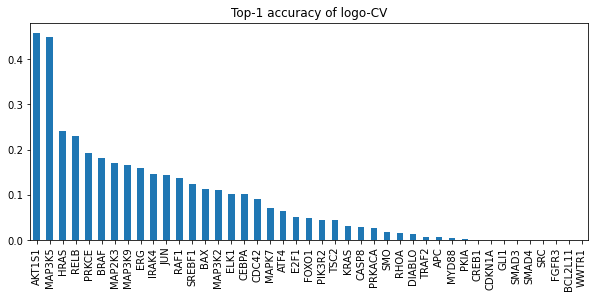

<IPython.core.display.Javascript object>

In [66]:
ax = logo_results_df.sort_values("top1", ascending=False).top1.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-1 accuracy of logo-CV")
plt.show()

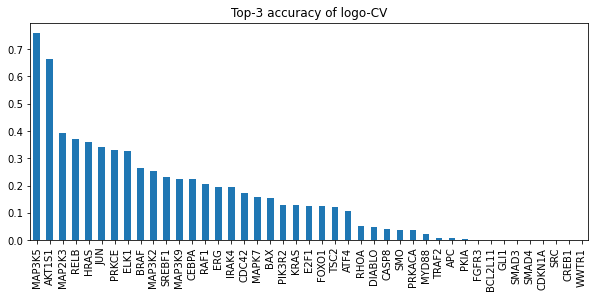

<IPython.core.display.Javascript object>

In [67]:
ax = logo_results_df.sort_values("top3", ascending=False).top3.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-3 accuracy of logo-CV")
plt.show()

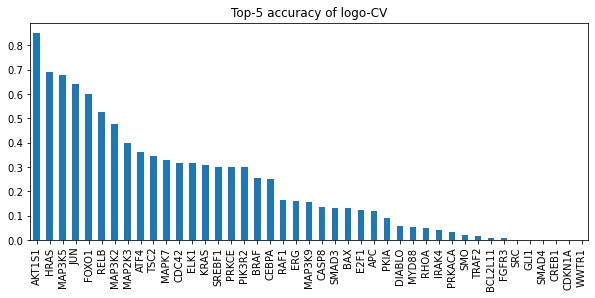

<IPython.core.display.Javascript object>

In [52]:
ax = logo_results_df.sort_values("top5", ascending=False).top5.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-5 accuracy of logo-CV")
plt.show()

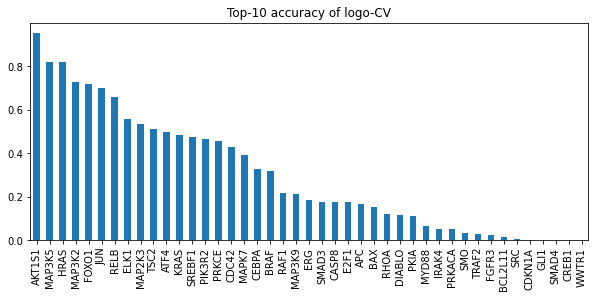

<IPython.core.display.Javascript object>

In [53]:
ax = logo_results_df.sort_values("top10", ascending=False).top10.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-10 accuracy of logo-CV")
plt.show()

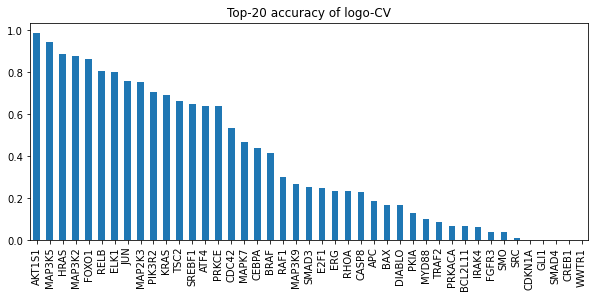

<IPython.core.display.Javascript object>

In [54]:
ax = logo_results_df.sort_values("top20", ascending=False).top20.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-20 accuracy of logo-CV")
plt.show()

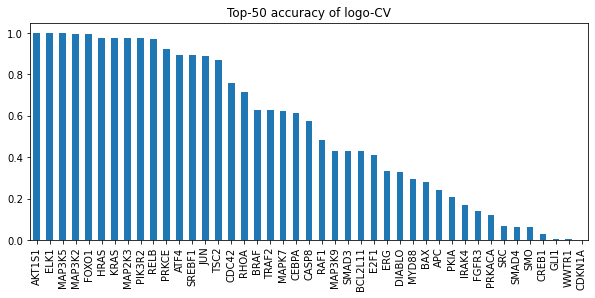

<IPython.core.display.Javascript object>

In [55]:
ax = logo_results_df.sort_values("top50", ascending=False).top50.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-50 accuracy of logo-CV")
plt.show()